# Data Extraction, Cleaning, and Explorantion

This notebook tests the data extraction and cleaning functions implemented according to the methodology from Dalle et al. (2025).

@note I use mathis a lot to clean data, theo could be useful to characterize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_extraction import *
from data_cleaning import *
from network_analysis import *

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data ETL

### Paper Methodology Summary:
- Exclude companies with incomplete information
- Exclude companies founded after 2014
- Exclude companies with inconsistent funding data
- Apply $150,000 minimum funding threshold
- Exclude companies with only accelerator funding (prevent endogeneity bias)
- Exclude companies with exit status (bankruptcy/takeover)

**Target**: Final sample of ~6,000 companies with ~688 accelerated companies (~11.5%)

### 1.1. Data Loading and Initial Exploration

In [2]:
# Load the raw data
print("Loading raw data from France dataset...")
raw_data = load_france_data('data/france')

print("\n" + "="*50)
print("RAW DATA OVERVIEW")
print("="*50)

for name, df in raw_data.items():
    print(f"\n{name.upper()}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}")

Loading raw data from France dataset...
✓ Loaded companies: 56797 rows, 43 columns
✓ Loaded funding_rounds: 14375 rows, 17 columns
✓ Loaded companies: 56797 rows, 43 columns
✓ Loaded funding_rounds: 14375 rows, 17 columns
✓ Loaded investments: 23420 rows, 35 columns
✓ Loaded investors: 4564 rows, 12 columns

RAW DATA OVERVIEW

COMPANIES:
Shape: (56797, 43)
Columns: ['uuid', 'name', 'cb_url', 'rank', 'homepage_url']...

FUNDING_ROUNDS:
Shape: (14375, 17)
Columns: ['uuid', 'name', 'country_code', 'country', 'region']...

INVESTMENTS:
Shape: (23420, 35)
Columns: ['uuid', 'funding_round_uuid', 'investor_uuid', 'is_lead_investor', 'investor_name']...

INVESTORS:
Shape: (4564, 12)
Columns: ['uuid', 'name', 'city', 'region', 'country_code']...
✓ Loaded investments: 23420 rows, 35 columns
✓ Loaded investors: 4564 rows, 12 columns

RAW DATA OVERVIEW

COMPANIES:
Shape: (56797, 43)
Columns: ['uuid', 'name', 'cb_url', 'rank', 'homepage_url']...

FUNDING_ROUNDS:
Shape: (14375, 17)
Columns: ['uuid',

In [3]:
# Get detailed data summary
data_summary = get_data_summary(raw_data)

# Display missing data information
print("MISSING DATA ANALYSIS:")
print("="*30)

for dataset_name, summary in data_summary.items():
    print(f"\n{dataset_name.upper()}:")
    missing_data = summary['missing_data']
    total_rows = summary['shape'][0]
    
    # Show only columns with missing data
    missing_cols = {k: v for k, v in missing_data.items() if v > 0}
    if missing_cols:
        for col, missing_count in list(missing_cols.items())[:5]:  # Show top 5
            pct_missing = (missing_count / total_rows) * 100
            print(f"  {col}: {missing_count} ({pct_missing:.1f}%)")
    else:
        print("  No missing data")

MISSING DATA ANALYSIS:

COMPANIES:
  category_groups_list: 26 (0.0%)
  closed_year: 55931 (98.5%)
  employee_count: 56 (0.1%)
  acquired_year: 53744 (94.6%)
  category: 130 (0.2%)

FUNDING_ROUNDS:
  country_code: 10 (0.1%)
  country: 10 (0.1%)
  region: 10 (0.1%)
  city: 10 (0.1%)
  ecosystem: 39 (0.3%)

INVESTMENTS:
  is_lead_investor: 14659 (62.6%)
  investor_types: 1716 (7.3%)
  investor_region: 398 (1.7%)
  investor_country: 398 (1.7%)
  investor_founded_year: 1405 (6.0%)

INVESTORS:
  city: 290 (6.4%)
  region: 290 (6.4%)
  country_code: 290 (6.4%)
  investor_types: 1104 (24.2%)
  founded_year: 669 (14.7%)


### 1.2. Data Cleaning

In [4]:
# Apply the complete cleaning process following the paper
print("APPLYING COMPLETE CLEANING PROCESS")
print("="*38)

cleaned_data = create_final_sample(raw_data, funding_threshold=150000)

print("\n" + "="*50)
print("CLEANING PROCESS COMPLETED")
print("="*50)

APPLYING COMPLETE CLEANING PROCESS
CREATING FINAL SAMPLE FOLLOWING PAPER METHODOLOGY

1. Cleaning companies data...
Initial companies count: 56797
Removed 9151 companies founded after 2017
Removed 4231 companies with exit status
Final companies count after cleaning: 43415
Total removed: 13382

2. Cleaning funding data...
Initial investments count: 23420
Removed 2533 investments with invalid funding amounts
Removed 9151 companies founded after 2017
Removed 4231 companies with exit status
Final companies count after cleaning: 43415
Total removed: 13382

2. Cleaning funding data...
Initial investments count: 23420
Removed 2533 investments with invalid funding amounts
Final investments count after cleaning: 20887
Total removed: 2533

3. Applying funding threshold...
Applying funding threshold of $150,000
Companies meeting funding threshold: 4854
Filtered companies: 2415
Filtered investments: 20650

4. Excluding accelerator-only companies...
Excluding companies with accelerator-only funding

c:\Projects\ATC\memoire\data_cleaning.py:189: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_investor_types = investments_df.groupby('org_uuid').apply(


In [5]:
# Get detailed statistics about the final sample
sample_stats = get_sample_statistics(cleaned_data)

print("FINAL SAMPLE STATISTICS")
print("="*25)

for key, value in sample_stats.items():
    if isinstance(value, dict):
        print(f"\n{key.replace('_', ' ').title()}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    elif isinstance(value, float):
        if 'rate' in key:
            print(f"{key.replace('_', ' ').title()}: {value:.1%}")
        elif 'funding' in key:
            print(f"{key.replace('_', ' ').title()}: ${value:,.0f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value:,}")

FINAL SAMPLE STATISTICS
Total Companies: 2,361
Total Investments: 10,163
Unique Investors: 2,343
Accelerated Companies: 483
Acceleration Rate: 20.5%
Avg Funding Per Company: $301,532,570
Median Funding Per Company: $8,752,348
Total Funding Volume: $711,918,398,201

Founding Years:
  min: 1995
  max: 2017

Investment Years:
  min: 1999
  max: 2025


### 1.3. Cleaned Data Visualisation and Validation

Company funding summary created for 2361 companies
FUNDING PATTERNS ANALYSIS
Companies in final sample: 2361
Average funding per company: $301,532,570
Median funding per company: $8,752,348
Average funding rounds per company: 4.3


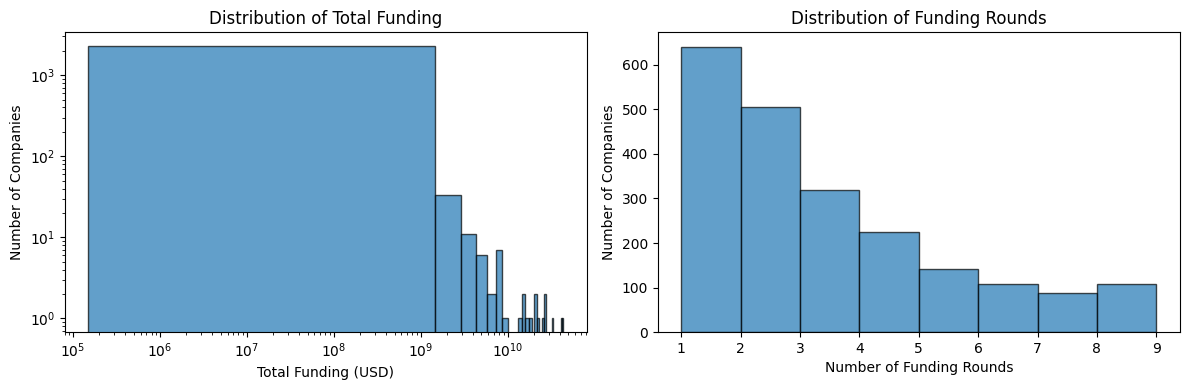

In [6]:
# Analyze funding patterns
companies_final = cleaned_data['companies']
investments_final = cleaned_data['investments']

# Create company funding summary
funding_summary = extract_company_funding_summary(companies_final, investments_final)

print("FUNDING PATTERNS ANALYSIS")
print("="*27)

print(f"Companies in final sample: {len(funding_summary)}")
print(f"Average funding per company: ${funding_summary['total_funding_sum'].mean():,.0f}")
print(f"Median funding per company: ${funding_summary['total_funding_sum'].median():,.0f}")
print(f"Average funding rounds per company: {funding_summary['funding_rounds_count'].mean():.1f}")

# Show funding distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(funding_summary['total_funding_sum'].dropna(), bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Total Funding (USD)')
plt.ylabel('Number of Companies')
plt.title('Distribution of Total Funding')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.hist(funding_summary['funding_rounds_count'].dropna(), bins=range(1, 10), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Number of Companies')
plt.title('Distribution of Funding Rounds')

plt.tight_layout()
plt.show()

In [7]:
# Analyze accelerator participation in final sample
print("ACCELERATOR PARTICIPATION ANALYSIS")
print("="*36)

# Identify accelerated companies in final sample
accelerated_in_final = identify_accelerated_companies(investments_final)

print(f"Companies with accelerator participation: {len(accelerated_in_final)}")
print(f"Acceleration rate in final sample: {len(accelerated_in_final)/len(companies_final):.1%}")

# Compare with paper's reported 688 out of 6000 (11.5%)
paper_rate = 688 / 6000
our_rate = len(accelerated_in_final) / len(companies_final)

print(f"\nComparison with paper:")
print(f"Paper acceleration rate: {paper_rate:.1%}")
print(f"Our acceleration rate: {our_rate:.1%}")

ACCELERATOR PARTICIPATION ANALYSIS
Identified 483 companies that participated in accelerator programs
Companies with accelerator participation: 483
Acceleration rate in final sample: 20.5%

Comparison with paper:
Paper acceleration rate: 11.5%
Our acceleration rate: 20.5%


Investment type categorization:
investment_category
other       3664
seed        2186
series_a    1975
series_b    1348
series_c     607
grant        288
angel         95
Name: count, dtype: int64
INVESTMENT TYPE ANALYSIS

Investment types in final sample:
  other: 3664 (36.1%)
  seed: 2186 (21.5%)
  series_a: 1975 (19.4%)
  series_b: 1348 (13.3%)
  series_c: 607 (6.0%)
  grant: 288 (2.8%)
  angel: 95 (0.9%)


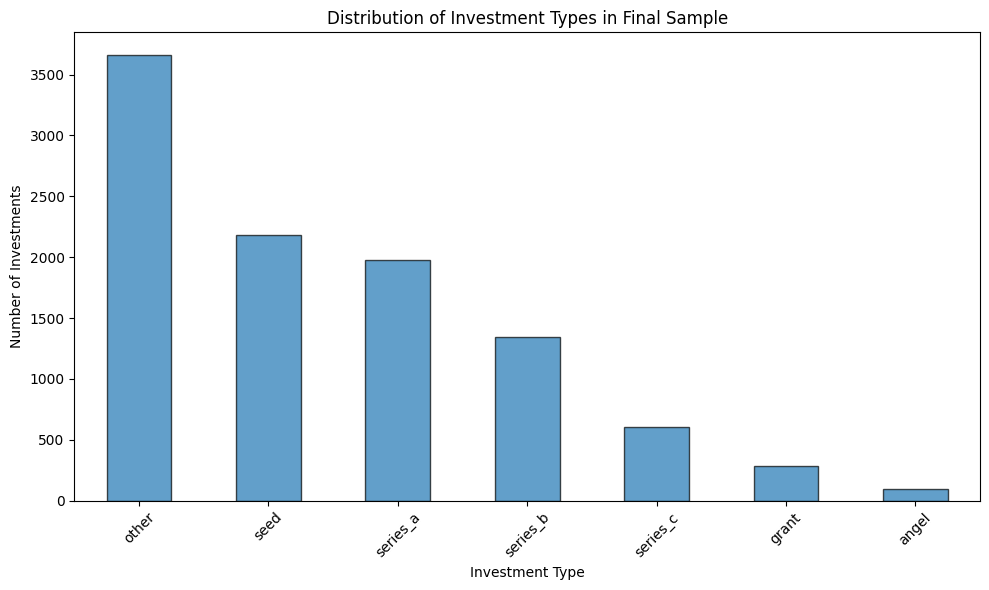

In [8]:
# Analyze investment types and timing
investments_categorized = categorize_investment_types(investments_final)

print("INVESTMENT TYPE ANALYSIS")
print("="*25)

# Investment type distribution
type_counts = investments_categorized['investment_category'].value_counts()
print("\nInvestment types in final sample:")
for inv_type, count in type_counts.items():
    pct = (count / len(investments_categorized)) * 100
    print(f"  {inv_type}: {count} ({pct:.1f}%)")

# Visualize investment types
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', alpha=0.7, edgecolor='black')
plt.title('Distribution of Investment Types in Final Sample')
plt.xlabel('Investment Type')
plt.ylabel('Number of Investments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top 10 sectors:
main_category
Commerce and Shopping           230
Biotechnology                   179
Consumer Electronics            134
Information Technology          126
Apps                            125
Health Care                     112
Energy                           97
Artificial Intelligence (AI)     97
Financial Services               95
Hardware                         91
Name: count, dtype: int64
SECTOR ANALYSIS

Top 10 sectors in final sample:
  Commerce and Shopping: 230 (9.7%)
  Biotechnology: 179 (7.6%)
  Consumer Electronics: 134 (5.7%)
  Information Technology: 126 (5.3%)
  Apps: 125 (5.3%)
  Health Care: 112 (4.7%)
  Energy: 97 (4.1%)
  Artificial Intelligence (AI): 97 (4.1%)
  Financial Services: 95 (4.0%)
  Hardware: 91 (3.9%)


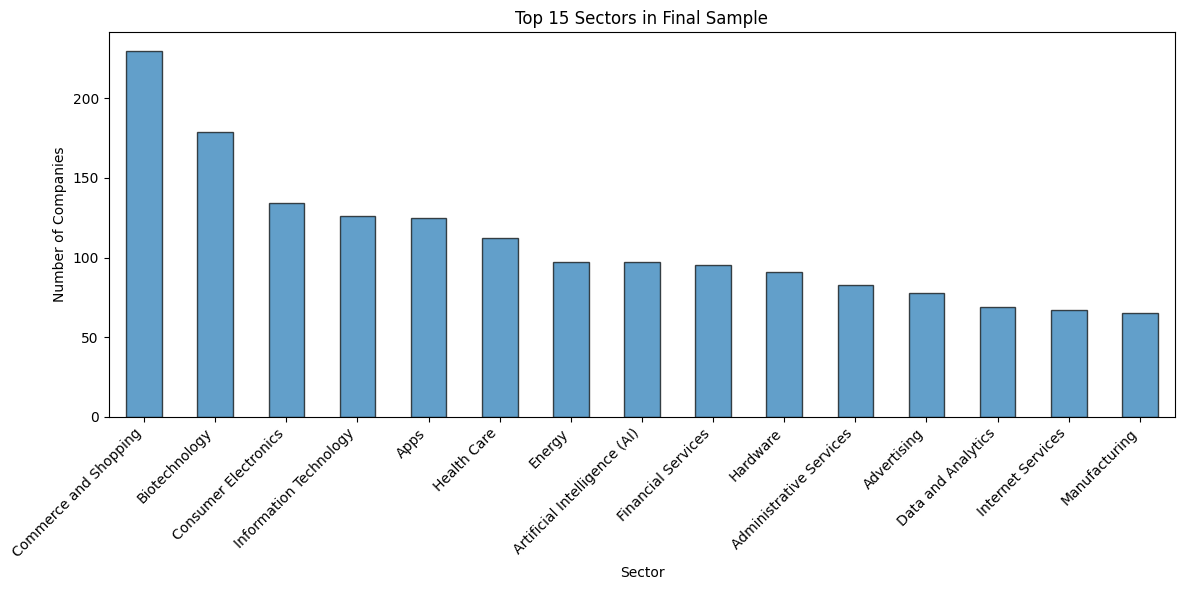

In [9]:
# Analyze sector information
companies_with_sectors = extract_sector_information(companies_final)

print("SECTOR ANALYSIS")
print("="*15)

if 'main_category' in companies_with_sectors.columns:
    sector_counts = companies_with_sectors['main_category'].value_counts()
    print(f"\nTop 10 sectors in final sample:")
    for sector, count in sector_counts.head(10).items():
        pct = (count / len(companies_with_sectors)) * 100
        print(f"  {sector}: {count} ({pct:.1f}%)")
        
    # Visualize top sectors
    plt.figure(figsize=(12, 6))
    sector_counts.head(15).plot(kind='bar', alpha=0.7, edgecolor='black')
    plt.title('Top 15 Sectors in Final Sample')
    plt.xlabel('Sector')
    plt.ylabel('Number of Companies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No sector information available")

TEMPORAL PATTERNS ANALYSIS

Founding years range: 1995 - 2017
Investment years range: 1999 - 2025


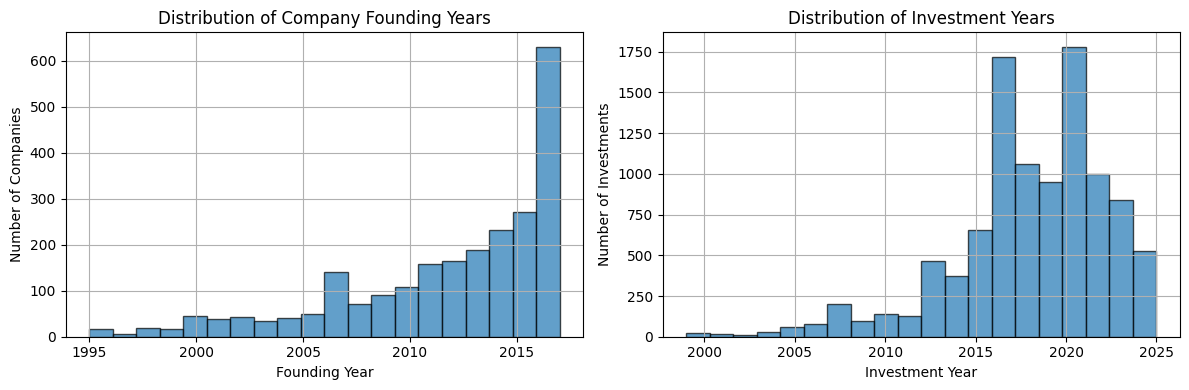

In [10]:
# Analyze temporal patterns
print("TEMPORAL PATTERNS ANALYSIS")
print("="*28)

if 'founded_year' in companies_final.columns:
    founding_years = companies_final['founded_year'].dropna()
    print(f"\nFounding years range: {founding_years.min():.0f} - {founding_years.max():.0f}")
    
    # Plot founding year distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    founding_years.hist(bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Founding Year')
    plt.ylabel('Number of Companies')
    plt.title('Distribution of Company Founding Years')
    
    if 'announced_year' in investments_final.columns:
        investment_years = investments_final['announced_year'].dropna()
        print(f"Investment years range: {investment_years.min():.0f} - {investment_years.max():.0f}")
        
        plt.subplot(1, 2, 2)
        investment_years.hist(bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Investment Year')
        plt.ylabel('Number of Investments')
        plt.title('Distribution of Investment Years')
    
    plt.tight_layout()
    plt.show()

### 1.3. Validation Against Literature Methodology

In [11]:
# Validate our results against the paper's methodology
print("VALIDATION AGAINST PAPER METHODOLOGY")
print("="*38)

# Check key criteria from the paper
print("\n1. Companies founded after 2014 excluded: ✓")
if 'founded_year' in companies_final.columns:
    max_year = companies_final['founded_year'].max()
    print(f"   Latest founding year in sample: {max_year}")

print("\n2. Minimum funding threshold of $150,000 applied: ✓")
company_totals = investments_final.groupby('org_uuid')['total_funding_usd'].sum()
min_funding = company_totals.min()
print(f"   Minimum total funding in sample: ${min_funding:,.0f}")

print("\n3. Companies with exit status excluded: ✓")
if 'status' in companies_final.columns:
    exit_statuses = companies_final['status'].value_counts()
    print(f"   Company statuses in final sample:")
    for status, count in exit_statuses.items():
        print(f"     {status}: {count}")

print("\n4. Accelerator-only companies excluded: ✓")
print(f"   All companies have at least one non-accelerator investor")

print("\n5. Sample size comparison:")
print(f"   Paper reported: 6,000 companies (688 accelerated)")
print(f"   Our sample: {len(companies_final):,} companies ({len(accelerated_in_final)} accelerated)")
print(f"   Our sample size is {(len(companies_final)/6000)*100:.1f}% of paper's size")

VALIDATION AGAINST PAPER METHODOLOGY

1. Companies founded after 2014 excluded: ✓
   Latest founding year in sample: 2017

2. Minimum funding threshold of $150,000 applied: ✓
   Minimum total funding in sample: $150,000

3. Companies with exit status excluded: ✓
   Company statuses in final sample:
     operating: 2361

4. Accelerator-only companies excluded: ✓
   All companies have at least one non-accelerator investor

5. Sample size comparison:
   Paper reported: 6,000 companies (688 accelerated)
   Our sample: 2,361 companies (483 accelerated)
   Our sample size is 39.4% of paper's size


In [12]:
# Final summary and export
print("FINAL SUMMARY")
print("="*15)

print(f"\nDataset successfully cleaned following Dalle et al. (2025) methodology:")
print(f"✓ {len(companies_final):,} companies in final sample")
print(f"✓ {len(investments_final):,} investment records")
print(f"✓ {investments_final['investor_uuid'].nunique():,} unique investors")
print(f"✓ {len(accelerated_in_final):,} companies participated in accelerators ({len(accelerated_in_final)/len(companies_final):.1%})")
print(f"✓ Average funding per company: ${funding_summary['total_funding_sum'].mean():,.0f}")
print(f"✓ Total funding volume: ${funding_summary['total_funding_sum'].sum():,.0f}")

print("\n" + "="*50)
print("DATA CLEANING AND VALIDATION COMPLETED SUCCESSFULLY!")
print("="*50)

FINAL SUMMARY

Dataset successfully cleaned following Dalle et al. (2025) methodology:
✓ 2,361 companies in final sample
✓ 10,163 investment records
✓ 2,343 unique investors
✓ 483 companies participated in accelerators (20.5%)
✓ Average funding per company: $301,532,570
✓ Total funding volume: $711,918,398,201

DATA CLEANING AND VALIDATION COMPLETED SUCCESSFULLY!


## 2. Networks Edges Definition

### 2.1. Coinvestments ignoring funding rounds

In [13]:
# Extract accelerator investments
print("EXTRACTING ACCELERATOR INVESTMENTS")
print("="*35)

accelerated_investments = extract_accelerator_investments(cleaned_data['investments'])

print("\nSample of accelerator investments:")
if 'company_name' in accelerated_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(accelerated_investments[display_cols].head())
else:
    print(accelerated_investments[['org_uuid', 'investor_name', 'investor_types']].head())

EXTRACTING ACCELERATOR INVESTMENTS
Found 675 accelerator investments
Unique companies in accelerators: 483

Sample of accelerator investments:
        company_name    investor_name investor_types  total_funding_usd
342   La Cartoonerie            WILCO    accelerator           676000.0
444          Force-A            WILCO    accelerator          7488077.0
631         Geodruid            WILCO    accelerator           177526.0
985          Homeloc        Netangels    accelerator           131845.0
1251        Mobypark  Startupbootcamp    accelerator           837000.0


In [14]:
# Extract VC investments
print("EXTRACTING VC INVESTMENTS")
print("="*25)

vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())

EXTRACTING VC INVESTMENTS
Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
            company_name      investor_name  \
1                 TVtrip  Balderton Capital   
2                 TVtrip            Partech   
9                 Twenga           3i Group   
29                 MyFab              Alven   
38  Inspirational Stores      Atlas Venture   

                         investor_types  total_funding_usd  
1                       venture capital         13770000.0  
2                       venture capital         13770000.0  
9   private equity firm,venture capital         14790959.0  
29                      venture capital         10176279.0  
38                      venture capital         11470000.0  


In [15]:
# Create investment pairs
print("CREATING INVESTMENT PAIRS")
print("="*30)

print("\nAccelerator-VC pairs:")
accelerator_vc_pairs = create_investment_pairs(accelerated_investments, vc_investments, 'acc', 'vc')
print(accelerator_vc_pairs[['org_uuid', 'investor_name_acc', 'investor_name_vc']].head())

print("\nVC-VC pairs:")
vc_vc_pairs = create_investment_pairs(vc_investments, vc_investments)
print(vc_vc_pairs[['org_uuid', 'investor_name_left', 'investor_name_right']].head())

CREATING INVESTMENT PAIRS

Accelerator-VC pairs:
Created 2910 investment pairs
Covering 407 unique investors
                               org_uuid investor_name_acc  \
0  6b399940-4fa0-b5a3-30ae-396d0fec6c09             WILCO   
1  e8a05c96-5073-f3cc-95a7-7f9bfa60dc50             WILCO   
2  e8a05c96-5073-f3cc-95a7-7f9bfa60dc50             WILCO   
3  e8a05c96-5073-f3cc-95a7-7f9bfa60dc50             WILCO   
4  e8a05c96-5073-f3cc-95a7-7f9bfa60dc50             WILCO   

                    investor_name_vc  
0                     Club Invest 77  
1  Scientipole Ile-de-France Capital  
2                             IXcore  
3                    Gogreen Capital  
4                            Capagro  

VC-VC pairs:
Created 43505 investment pairs
Covering 1835 unique investors
                               org_uuid investor_name_left investor_name_right
0  a0f5e737-d973-703c-7f66-0fc31d0e4b5b  Balderton Capital   Balderton Capital
1  a0f5e737-d973-703c-7f66-0fc31d0e4b5b  Balderton Capit

### 2.2. Coinvestments sensible to funding rounds

In [16]:
# Extract VC series_a investments
print("EXTRACTING VC SERIES A INVESTMENTS")
print("="*25)

series_a_vc_investments = extract_investments_by_type(cleaned_data['investments'], cleaned_data['funding_rounds'], 'series_a')

print("\nSample of series A investments:")
if 'company_name' in series_a_vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(series_a_vc_investments[display_cols].head())
else:
    print(series_a_vc_investments[['org_uuid', 'investor_name', 'investment_type']].head())

EXTRACTING VC SERIES A INVESTMENTS
Found 1589 funding rounds with 'series_a' type
Found 1975 investments from these funding rounds
Unique companies with series_a investments: 692

Sample of series A investments:
   company_name         investor_name   investor_types  total_funding_usd
1        TVtrip     Balderton Capital  venture capital         13770000.0
2        TVtrip               Partech  venture capital         13770000.0
29        MyFab                 Alven  venture capital         10176279.0
41          C4M  CM-CIC Capital Prive  venture capital          3604819.0
69         GOOM   Wellington Partners  venture capital         16000000.0


In [17]:
# Extract VC series_b investments   
print("EXTRACTING VC SERIES B INVESTMENTS")
print("="*25)
series_b_vc_investments = extract_investments_by_type(cleaned_data['investments'], cleaned_data['funding_rounds'], 'series_b')

print("\nSample of series B investments:")
if 'company_name' in series_b_vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(series_b_vc_investments[display_cols].head())
else:
    print(series_b_vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())

EXTRACTING VC SERIES B INVESTMENTS
Found 618 funding rounds with 'series_b' type
Found 1348 investments from these funding rounds
Unique companies with series_b investments: 321

Sample of series B investments:
            company_name      investor_name  \
11                Viadeo  Idinvest Partners   
38  Inspirational Stores      Atlas Venture   
39  Inspirational Stores             Apicap   
61                TVtrip  Balderton Capital   
62                TVtrip            Partech   

                         investor_types  total_funding_usd  
11                  private equity firm         57026464.0  
38                      venture capital         11470000.0  
39  private equity firm,venture capital         11470000.0  
61                      venture capital         13770000.0  
62                      venture capital         13770000.0  


In [18]:
# Create investment pairs
print("CREATING INVESTMENT PAIRS")
print("="*30)

print("Serie B VC - Series B VC pairs:")
series_a_b_vc_pairs = create_investment_pairs(series_a_vc_investments, series_b_vc_investments, 'vc_a', 'vc_b')
print(series_a_b_vc_pairs[['org_uuid', 'investor_name_vc_a', 'investor_name_vc_b']].head())

CREATING INVESTMENT PAIRS
Serie B VC - Series B VC pairs:
Created 3699 investment pairs
Covering 232 unique investors
                               org_uuid investor_name_vc_a investor_name_vc_b
0  a0f5e737-d973-703c-7f66-0fc31d0e4b5b  Balderton Capital  Balderton Capital
1  a0f5e737-d973-703c-7f66-0fc31d0e4b5b  Balderton Capital            Partech
2  a0f5e737-d973-703c-7f66-0fc31d0e4b5b            Partech  Balderton Capital
3  a0f5e737-d973-703c-7f66-0fc31d0e4b5b            Partech            Partech
4  ce608898-ff6f-a8f9-89cb-2fb2b47b6da3              Alven              Alven


## 3. Accelerator-VC Bipartite Network

**TO DO**: let it clear: I am tending to explore network properties to define objectivelly the french ecosystem. COmparison with US ecosystem (using the same method / codebase) would be interesting, as literature on US ecosystems properties interpretation is broader...

### 3.1 Theoretical Framework

- **TO DO**: let it clear we are not always dealing with bipartite networks, but when it is the case specific interpretation is given (polinizator-plant could be mentioned here...)

Bipartite networks can provide insights for analyzing startup ecosystems. In the current work we try to build such network by using either one of the following representations of edges :

1. **Accelerator-VC**: Represent partnerships between accelerators and venture capital firms through shared portfolio companies
2. **Series A-B VC**: Capture progression patterns between early-stage (Series A) and growth-stage (Series B) investors

For instance, if a given VC X decides to invest in a company incubated by Accelerator Y, then the tuple/pair (X, Y) represents an engde in our bipertite network.

**Metrics Explored here:**

For Accelerator-VC network:

- **Network Density**: Proportion of actual connections to all possible connections. Low density (< 0.01) suggests selective partnerships; high density (> 0.1) indicates mature, integrated ecosystems.
  - **TO DO**: analyse Gini Index as well (measure inequality)
- **Nestedness (NODF)**: Measures hierarchical organization (0-100 scale). High scores (> 50) indicate that less connected players tend to partner with highly connected ones
- **Cross-Assortativity**: Correlation between activity levels of connected partners. Positive values suggest 'birds of a feather' matching; negative values indicate complementary partnerships
- **Bipartite Projections**: Transform bipartite network into single-mode networks showing indirect connections through shared partners
- **TO DO**: **Connected Components**: Number of disconnected network clusters. Single component indicates integrated ecosystem
  - **TO DO**: understand and plot such Components

For Series A-B VC network:

- **State Specialization**
- **Cross-Stage Progression**

**TO DO**: clustering coefficient

... continue it

### 3.2. Network Analysis

This analysis examines the partnership patterns between accelerators and venture capital firms. The bipartite structure allows us to:

- Identify which accelerators have the strongest VC networks
- Understand hierarchical patterns in ecosystem relationships
- Detect indirect connections between similar player types
- Assess the integration level of the startup ecosystem
- TO DO: assess inequlity through Gini-ish analysis

Accelerator-VC Network Edge Statistics:
  Unique co-investment relationships: 1,352
  Total funding volume: $311,602,872,983
  Average funding per relationship: $230,475,498
  Median funding per relationship: $32,854,794


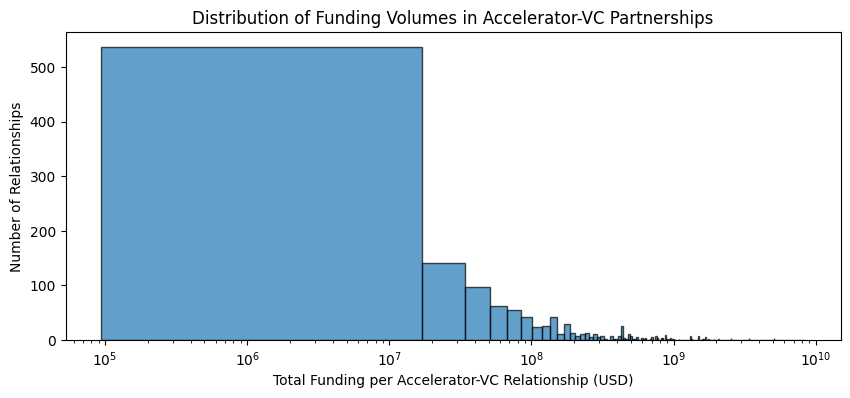

In [39]:
# Extract unique edges from accelerator-VC pairs
acc_vc_edges = extract_bipartite_edges_from_pairs(
    accelerator_vc_pairs, 
    'investor_name_acc', 
    'investor_name_vc',
    'total_funding_usd'
)

print(f"Accelerator-VC Network Edge Statistics:")
print(f"  Unique co-investment relationships: {len(acc_vc_edges):,}")
print(f"  Total funding volume: ${acc_vc_edges['total_funding_usd'].sum():,.0f}")
print(f"  Average funding per relationship: ${acc_vc_edges['total_funding_usd'].mean():,.0f}")
print(f"  Median funding per relationship: ${acc_vc_edges['total_funding_usd'].median():,.0f}")

# Show distribution of edge weights
plt.figure(figsize=(10, 4))
plt.hist(acc_vc_edges['total_funding_usd'], bins=500, alpha=0.7, edgecolor='black')
plt.xlabel('Total Funding per Accelerator-VC Relationship (USD)')
plt.ylabel('Number of Relationships')
plt.title('Distribution of Funding Volumes in Accelerator-VC Partnerships')
plt.xscale('log')
plt.show()

#### 3.2.1 Data Quality Assessment

Before proceeding with network analysis, we must address a common challenge in startup ecosystem data: **dual-role organizations**. Many entities function as both accelerators and VCs, which violates the bipartite assumption that nodes belong to only one set.

This overlap is **theoretically meaningful** rather than a data error:
- Organizations like Techstars, 500 Startups, and Y Combinator operate accelerator programs while also making direct investments
- This dual role reflects the evolution of the startup ecosystem toward integrated service providers
- Our analysis uses suffix handling to distinguish between roles (e.g., 'Techstars_Accelerators' vs 'Techstars_VCs')

In [ ]:
# Check for overlapping nodes in the accelerator-VC data
overlap_info = check_bipartite_overlap(
    acc_vc_edges,
    'investor_name_acc',
    'investor_name_vc'
)

print(f"Bipartite Structure Analysis:")
print(f"  Unique accelerators: {overlap_info['set_1_size']:,}")
print(f"  Unique VCs: {overlap_info['set_2_size']:,}")
print(f"  Dual-role organizations: {overlap_info['overlap_size']:,}")
print(f"  Overlap rate: {(overlap_info['overlap_size']/(overlap_info['set_1_size']+overlap_info['set_2_size'])*100):.1f}%")

if overlap_info['overlap_size'] > 0:
    print(f"\nDual-role organizations (first 10):")
    for entity in list(overlap_info['overlap_nodes'])[:10]:
        print(f"  • {entity}")
    
    dual_role_rate = overlap_info['overlap_size'] / (overlap_info['set_1_size'] + overlap_info['set_2_size']) * 100
    print(f"\nInterpretation:")
    if dual_role_rate > 20:
        print(f"  High dual-role rate ({dual_role_rate:.1f}%) suggests ecosystem convergence")
    elif dual_role_rate > 10:
        print(f"  Moderate dual-role rate ({dual_role_rate:.1f}%) indicates evolving ecosystem")
    else:
        print(f"  Low dual-role rate ({dual_role_rate:.1f}%) suggests distinct accelerator/VC roles")

CHECKING FOR OVERLAPPING NODES IN ACCELERATOR-VC DATA

Overlap Analysis:
  Accelerators: 117
  VCs: 627
  Overlapping entities: 1
  Is truly bipartite: False

First 10 overlapping entities:
  - Raise Ventures

These entities appear as both accelerators and VCs in the data.
This is common since some organizations play both roles.


In [ ]:
# Robust bipartite analysis with overlap handling
acc_vc_analysis = analyze_bipartite_structure_robust(
    acc_vc_edges,
    'investor_name_acc',
    'investor_name_vc',
    'total_funding_usd',
    'Accelerators',
    'VCs',
    handle_overlap='suffix'
)

# Extract core metrics for analysis
metrics = acc_vc_analysis['basic_metrics']
nestedness = acc_vc_analysis['nestedness']
cross_assort = acc_vc_analysis['cross_assortativity']
projections = acc_vc_analysis['projections']

print(f"Accelerator-VC Network Structure:")
print(f"  Total nodes: {metrics['num_nodes']:,} ({metrics['set_0_size']} accelerators + {metrics['set_1_size']} VCs)")
print(f"  Total edges: {metrics['num_edges']:,}")
print(f"  Network density: {metrics['density']:.6f}")
print(f"  Connected components: {metrics['num_components']}")

#### 3.2.2 Network Density (Fragmentation, Selectivity, and Maturity)

Network density represents the proportion of actual connections to all theoretically possible connections between accelerators and VCs. The interpretation depends on the observed value:

- **TO DO**: search literature to define such levels
  - The "social effects" are somehow agreed in the literature given network characteriscs, what is not agreeded is the exat number to define what is low, medium, and high density. In this case we could use US data to understand France ecosystem
- **TO DO**: explore the idea of trying to understand french ecosystem by comparing to US metrics
- For now we are asumming the following:
  - **Very Low Density (< 0.001)**: Highly fragmented ecosystem with isolated clusters
  - **Low Density (0.001-0.01)**: Selective partnerships, possibly geography or sector-driven
  - **Medium Density (0.01-0.1)**: Moderately integrated ecosystem with emerging cross-connections
  - **High Density (> 0.1)**: Mature, well-integrated ecosystem with broad collaboration

The density metric is particularly meaningful in startup ecosystems because it reflects **information flow efficiency** between accelerators and VCs, **market maturity** and integration levels **barriers to partnership formation** (geographic, sectoral, cultural)
- **TO DO**: put sources here

In [41]:
# Analyze network density implications
density = metrics['density']
total_possible_edges = metrics['set_0_size'] * metrics['set_1_size']
actual_edges = metrics['num_edges']

print(f"Network Density Analysis:")
print(f"  Actual connections: {actual_edges:,}")
print(f"  Possible connections: {total_possible_edges:,}")
print(f"  Density: {density:.6f} ({density*100:.4f}%)")

# Contextual interpretation
if density < 0.001:
    density_interpretation = "Very Low - Highly fragmented ecosystem"
    implications = [
        "Significant barriers to accelerator-VC partnerships",
        "Potential for intermediary platforms or matchmaking services",
        "Geographic or sectoral silos may dominate",
        "Information asymmetries likely prevalent"
    ]
elif density < 0.01:
    density_interpretation = "Low - Selective partnership patterns"
    implications = [
        "Partnerships driven by specific criteria (geography, sector, reputation)",
        "Emerging ecosystem with room for integration",
        "Quality over quantity in partnership formation",
        "Potential for network effects as ecosystem matures"
    ]
elif density < 0.1:
    density_interpretation = "Medium - Moderately integrated ecosystem"
    implications = [
        "Balanced mix of selective and broad partnerships",
        "Evidence of ecosystem maturation",
        "Cross-pollination of ideas and deal flow",
        "Reduced information asymmetries"
    ]
else:
    density_interpretation = "High - Mature, well-integrated ecosystem"
    implications = [
        "Extensive collaboration and information sharing",
        "Highly efficient deal flow and resource allocation",
        "Potential for groupthink or reduced diversity",
        "Strong network effects benefiting ecosystem participants"
    ]

print(f"\nInterpretation: {density_interpretation}")
print(f"\nStrategic Implications:")
for i, implication in enumerate(implications, 1):
    print(f"  {i}. {implication}")

Network Density Analysis:
  Actual connections: 1,352
  Possible connections: 73,359
  Density: 0.018430 (1.8430%)

Interpretation: Medium - Moderately integrated ecosystem

Strategic Implications:
  1. Balanced mix of selective and broad partnerships
  2. Evidence of ecosystem maturation
  3. Cross-pollination of ideas and deal flow
  4. Reduced information asymmetries


#### 3.2.3 Nestedness (Hierarchical Structure)

The NODF (Nestedness based on Overlap and Decreasing Fill) metric measures whether the network exhibits a hierarchical structure. In bipartite networks, nestedness indicates whether:

- **Less connected accelerators** tend to partner primarily with **highly connected VCs**
- **Less connected VCs** tend to partner primarily with **highly connected accelerators**

**Theoretical Significance:**
- **High Nestedness (> 60)**: Suggests a 'core-periphery' structure with tier-1 players dominating
- **Medium Nestedness (30-60)**: Indicates mixed partnership strategies
- **Low Nestedness (< 30)**: Implies more egalitarian, distributed partnership patterns

With this metric we can understand **market power dynamics** and **entry barriers** in startup ecosystems.

In [42]:
# Analyze nestedness patterns
nodf_total = nestedness['nodf_total']
nodf_accs = nestedness['nodf_rows']
nodf_vcs = nestedness['nodf_cols']

print(f"Nestedness Analysis (NODF Scores):")
print(f"  Overall nestedness: {nodf_total:.2f}/100")
print(f"  Accelerator nestedness: {nodf_accs:.2f}/100")
print(f"  VC nestedness: {nodf_vcs:.2f}/100")

# Determine hierarchy level
if nodf_total > 70:
    hierarchy_level = "Very High"
    hierarchy_desc = "Strong core-periphery structure with clear tier-1 dominance"
elif nodf_total > 50:
    hierarchy_level = "High"
    hierarchy_desc = "Significant hierarchical organization with tier-based partnerships"
elif nodf_total > 30:
    hierarchy_level = "Medium"
    hierarchy_desc = "Mixed partnership strategies with moderate hierarchy"
else:
    hierarchy_level = "Low"
    hierarchy_desc = "Egalitarian partnership patterns with minimal hierarchy"

print(f"\nHierarchy Assessment: {hierarchy_level} ({hierarchy_desc})")

# Asymmetry analysis
acc_vc_asymmetry = abs(nodf_accs - nodf_vcs)
if acc_vc_asymmetry > 20:
    if nodf_accs > nodf_vcs:
        asymmetry_insight = "Accelerators show stronger hierarchical patterns than VCs"
        asymmetry_explanation = "Small accelerators primarily connect to established VCs, while VC partnerships are more distributed"
    else:
        asymmetry_insight = "VCs show stronger hierarchical patterns than accelerators"
        asymmetry_explanation = "Small VCs primarily connect to established accelerators, while accelerator partnerships are more distributed"
    print(f"\nAsymmetry Detected: {asymmetry_insight}")
    print(f"Explanation: {asymmetry_explanation}")
else:
    print(f"\nSymmetric Hierarchy: Both accelerators and VCs show similar nestedness patterns")

# Strategic implications based on nestedness
print(f"\nStrategic Implications of {hierarchy_level} Hierarchy:")
if nodf_total > 60:
    implications = [
        "New accelerators should prioritize partnerships with tier-1 VCs",
        "Tier-1 players have significant gatekeeper power",
        "Network position strongly influences deal access",
        "Policy interventions may be needed to support smaller players"
    ]
elif nodf_total > 30:
    implications = [
        "Multiple viable partnership strategies exist",
        "Specialization may be more important than size",
        "Geographic or sectoral niches offer opportunities",
        "Moderate network effects favor established relationships"
    ]
else:
    implications = [
        "Partnership opportunities widely distributed",
        "Lower barriers to entry for new players",
        "Innovation and specialization over scale",
        "Competitive ecosystem with multiple success paths"
    ]

for i, implication in enumerate(implications, 1):
    print(f"  {i}. {implication}")

Nestedness Analysis (NODF Scores):
  Overall nestedness: 11.03/100
  Accelerator nestedness: 4.99/100
  VC nestedness: 17.08/100

Hierarchy Assessment: Low (Egalitarian partnership patterns with minimal hierarchy)

Symmetric Hierarchy: Both accelerators and VCs show similar nestedness patterns

Strategic Implications of Low Hierarchy:
  1. Partnership opportunities widely distributed
  2. Lower barriers to entry for new players
  3. Innovation and specialization over scale
  4. Competitive ecosystem with multiple success paths


#### 3.2.4 Cross-Assortativity (Matching Preferences Analysis)

Cross-assortativity measures the correlation between the activity levels (degree centrality) of connected accelerators and VCs. This metric reveals **partner selection strategies**:

- **Positive Assortativity (> 0.3)**: 'Birds of a feather' - highly active accelerators prefer highly active VCs
- **Negative Assortativity (< -0.3)**: Complementary matching - active players seek less active partners
- **Neutral Assortativity (-0.3 to 0.3)**: Activity level not a primary matching criterion

There are also some possible **Economic Interpretation:**
- High positive values suggest **homophily** and potential **elite clustering**
- Negative values may indicate **mentorship patterns** or **resource complementarity**
- Neutral values suggest **diverse matching criteria** (sector, geography, stage focus)

In [43]:
# Analyze cross-assortativity patterns
assortativity = cross_assort['cross_assortativity']
p_value = cross_assort['p_value']
n_edges = cross_assort['num_edges']

print(f"Cross-Assortativity Analysis:")
print(f"  Correlation coefficient: {assortativity:.4f}")
print(f"  Statistical significance: p = {p_value:.4f}")
print(f"  Sample size: {n_edges:,} partnerships")

# Statistical significance assessment
if p_value < 0.001:
    significance = "Highly significant (p < 0.001)"
elif p_value < 0.01:
    significance = "Very significant (p < 0.01)"
elif p_value < 0.05:
    significance = "Significant (p < 0.05)"
else:
    significance = "Not statistically significant (p ≥ 0.05)"

print(f"  Significance level: {significance}")

# Interpret assortativity magnitude and direction
if assortativity > 0.5:
    assort_level = "Very Strong Positive"
    pattern_desc = "Highly active players strongly prefer other highly active partners"
    economic_meaning = "Elite clustering with potential exclusion of smaller players"
elif assortativity > 0.3:
    assort_level = "Strong Positive"
    pattern_desc = "Active players tend to partner with other active players"
    economic_meaning = "Homophily-driven partnerships with moderate elite effects"
elif assortativity > 0.1:
    assort_level = "Moderate Positive"
    pattern_desc = "Weak tendency for similar activity levels to partner"
    economic_meaning = "Mixed matching strategies with slight homophily bias"
elif assortativity > -0.1:
    assort_level = "Neutral"
    pattern_desc = "No clear preference based on activity levels"
    economic_meaning = "Diverse matching criteria beyond simple activity measures"
elif assortativity > -0.3:
    assort_level = "Moderate Negative"
    pattern_desc = "Weak tendency for different activity levels to partner"
    economic_meaning = "Some evidence of complementary partnerships"
else:
    assort_level = "Strong Negative"
    pattern_desc = "Active players strongly prefer less active partners"
    economic_meaning = "Clear complementary matching or mentorship patterns"

print(f"\nAssortativity Pattern: {assort_level}")
print(f"Description: {pattern_desc}")
print(f"Economic Meaning: {economic_meaning}")

# Strategic implications
print(f"\nStrategic Implications for Partnership Formation:")
if assortativity > 0.3 and p_value < 0.05:
    implications = [
        "Building reputation and activity levels crucial for attracting top partners",
        "Risk of 'rich-get-richer' dynamics excluding smaller players",
        "Network position becomes self-reinforcing advantage",
        "May benefit from policies promoting inclusive partnerships"
    ]
elif assortativity < -0.3 and p_value < 0.05:
    implications = [
        "Active players may be seeking complementary capabilities",
        "Mentorship or development-focused partnerships prevalent",
        "Opportunities for smaller players to access established networks",
        "Resource sharing and capability complementarity drive partnerships"
    ]
else:
    implications = [
        "Partnership decisions based on factors beyond simple activity levels",
        "Geographic, sectoral, or strategic fit may dominate",
        "Multiple viable approaches to partnership formation",
        "Less predictable but potentially more diverse ecosystem"
    ]

for i, implication in enumerate(implications, 1):
    print(f"  {i}. {implication}")

Cross-Assortativity Analysis:
  Correlation coefficient: -0.0558
  Statistical significance: p = 0.0404
  Sample size: 1,352 partnerships
  Significance level: Significant (p < 0.05)

Assortativity Pattern: Neutral
Description: No clear preference based on activity levels
Economic Meaning: Diverse matching criteria beyond simple activity measures

Strategic Implications for Partnership Formation:
  1. Partnership decisions based on factors beyond simple activity levels
  2. Geographic, sectoral, or strategic fit may dominate
  3. Multiple viable approaches to partnership formation
  4. Less predictable but potentially more diverse ecosystem


#### 3.2.5 Bipartite Projections (Indirect Network Effects)

- Mot kley: Indirect Network Effects
- **TO DO**: mention that projection removes the "bipartite" characteristic making our graph "normal" again. Further analysis could explore such networks properties as well (but the interpretation is nebulous for me now)

Bipartite projections transform our two-mode network into single-mode networks, revealing **indirect connections**:

1. **Accelerator Projection**: Connects accelerators that share VC partners
2. **VC Projection**: Connects VCs that share accelerator partners

Through these projections we can try to understand:
- **Information diffusion** pathways in the ecosystem
- **Indirect collaboration** opportunities
- **Competitive dynamics** between similar players
- **Network effects** and clustering patterns

The relative density of projections indicates which player type serves as the primary **intermediary** in the ecosystem.

In [44]:
# Analyze bipartite projections
acc_projection = projections['projection_0']
vc_projection = projections['projection_1']

acc_proj_density = nx.density(acc_projection)
vc_proj_density = nx.density(vc_projection)

print(f"Bipartite Projections Analysis:")
print(f"\nAccelerator Projection (connected via shared VCs):")
print(f"  Nodes: {acc_projection.number_of_nodes():,}")
print(f"  Edges: {acc_projection.number_of_edges():,}")
print(f"  Density: {acc_proj_density:.6f}")

print(f"\nVC Projection (connected via shared accelerators):")
print(f"  Nodes: {vc_projection.number_of_nodes():,}")
print(f"  Edges: {vc_projection.number_of_edges():,}")
print(f"  Density: {vc_proj_density:.6f}")

# Analyze projection density relationship
density_ratio = acc_proj_density / vc_proj_density if vc_proj_density > 0 else float('inf')

print(f"\nProjection Density Comparison:")
print(f"  Accelerator/VC density ratio: {density_ratio:.2f}")

if density_ratio > 2:
    intermediary_role = "VCs act as primary ecosystem intermediaries"
    explanation = "VCs connect many accelerators, creating dense accelerator networks"
    implications = [
        "VC partnerships critical for accelerator network position",
        "Information flows primarily through VC networks",
        "Accelerator collaboration facilitated by shared VCs",
        "VC selection becomes strategic network decision"
    ]
elif density_ratio < 0.5:
    intermediary_role = "Accelerators act as primary ecosystem intermediaries"
    explanation = "Accelerators connect many VCs, creating dense VC networks"
    implications = [
        "Accelerator partnerships critical for VC network position",
        "Information flows primarily through accelerator networks",
        "VC collaboration facilitated by shared accelerators",
        "Accelerator selection becomes strategic network decision"
    ]
else:
    intermediary_role = "Balanced intermediation between accelerators and VCs"
    explanation = "Both player types contribute similarly to network connectivity"
    implications = [
        "Symmetric importance of both accelerator and VC relationships",
        "Multiple pathways for information flow and collaboration",
        "No single player type dominates network effects",
        "Partnership strategies should consider both dimensions"
    ]

print(f"\nIntermediation Pattern: {intermediary_role}")
print(f"Explanation: {explanation}")
print(f"\nStrategic Implications:")
for i, implication in enumerate(implications, 1):
    print(f"  {i}. {implication}")

# Analyze top connected nodes in projections
if acc_projection.number_of_edges() > 0:
    acc_degrees = dict(acc_projection.degree())
    top_accs = sorted(acc_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop Connected Accelerators (via shared VCs):")
    for i, (acc, degree) in enumerate(top_accs, 1):
        print(f"  {i}. {acc.replace('_Accelerators', '')}: {degree} indirect connections")

if vc_projection.number_of_edges() > 0:
    vc_degrees = dict(vc_projection.degree())
    top_vcs = sorted(vc_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop Connected VCs (via shared accelerators):")
    for i, (vc, degree) in enumerate(top_vcs, 1):
        print(f"  {i}. {vc.replace('_VCs', '')}: {degree} indirect connections")

Bipartite Projections Analysis:

Accelerator Projection (connected via shared VCs):
  Nodes: 117
  Edges: 909
  Density: 0.133952

VC Projection (connected via shared accelerators):
  Nodes: 627
  Edges: 33,502
  Density: 0.170710

Projection Density Comparison:
  Accelerator/VC density ratio: 0.78

Intermediation Pattern: Balanced intermediation between accelerators and VCs
Explanation: Both player types contribute similarly to network connectivity

Strategic Implications:
  1. Symmetric importance of both accelerator and VC relationships
  2. Multiple pathways for information flow and collaboration
  3. No single player type dominates network effects
  4. Partnership strategies should consider both dimensions

Top Connected Accelerators (via shared VCs):
  1. WILCO: 85 indirect connections
  2. AGORANOV: 78 indirect connections
  3. Crédit Agricole: 69 indirect connections
  4. SAP.iO: 56 indirect connections
  5. BOOST Programs: 55 indirect connections

Top Connected VCs (via shared

#### 3.X

@todo analyse specialization on the VCs in the ACC VC bipartite graph

In [46]:
# Analyze stage specialization patterns
total_series_a_vcs = ab_overlap['set_1_size']
total_series_b_vcs = ab_overlap['set_2_size']
multi_stage_vcs = ab_overlap['overlap_size']

specialization_rate_a = (total_series_a_vcs - multi_stage_vcs) / total_series_a_vcs if total_series_a_vcs > 0 else 0
specialization_rate_b = (total_series_b_vcs - multi_stage_vcs) / total_series_b_vcs if total_series_b_vcs > 0 else 0

print(f"Stage Specialization Analysis:")
print(f"  Series A specialists: {total_series_a_vcs - multi_stage_vcs:,} ({specialization_rate_a*100:.1f}%)")
print(f"  Series B specialists: {total_series_b_vcs - multi_stage_vcs:,} ({specialization_rate_b*100:.1f}%)")
print(f"  Multi-stage generalists: {multi_stage_vcs:,}")

# Market structure interpretation
avg_specialization = (specialization_rate_a + specialization_rate_b) / 2

if avg_specialization > 0.7:
    market_structure = "Highly Specialized"
    structure_desc = "Clear separation between early and growth-stage VC markets"
    implications = [
        "Startups need distinct strategies for each funding stage",
        "Limited overlap in VC networks across stages",
        "Stage-specific expertise and value-add dominate",
        "Potential market inefficiencies at stage transitions"
    ]
elif avg_specialization > 0.4:
    market_structure = "Moderately Specialized"
    structure_desc = "Mixed market with both specialists and generalists"
    implications = [
        "Multiple pathways for funding progression",
        "Some VCs provide continuity across stages",
        "Balanced competition between specialists and generalists",
        "Flexibility in funding strategy approaches"
    ]
else:
    market_structure = "Generalist-Dominated"
    structure_desc = "Most VCs invest across multiple stages"
    implications = [
        "Strong continuity in investor relationships",
        "Reduced complexity in funding transitions",
        "Comprehensive VC value-add across company lifecycle",
        "Potential for long-term investor partnerships"
    ]

print(f"\nMarket Structure: {market_structure}")
print(f"Description: {structure_desc}")
print(f"\nImplications for Funding Strategy:")
for i, implication in enumerate(implications, 1):
    print(f"  {i}. {implication}")

Stage Specialization Analysis:
  Series A specialists: 88 (27.2%)
  Series B specialists: 281 (54.5%)
  Multi-stage generalists: 235

Market Structure: Moderately Specialized
Description: Mixed market with both specialists and generalists

Implications for Funding Strategy:
  1. Multiple pathways for funding progression
  2. Some VCs provide continuity across stages
  3. Balanced competition between specialists and generalists
  4. Flexibility in funding strategy approaches


This section provides a systematic comparison of the different network structures we've analyzed, highlighting their unique characteristics and relative patterns.

@todo instead of generating comparison here, just show the acc-vc network properties

Comprehensive Network Comparison:
       Network  Nodes  Edges  Density  Set_0_Size  Set_1_Size  Avg_Clustering  Components  NODF_Score  Cross_Assortativity  Assortativity_p_value
Accelerator-VC    744   1352   0.0184         117         627          0.3970          12     11.0323              -0.0558                 0.0404
Series_A-B_VCs    839   2963   0.0178         323         516          0.2236          12      5.9870              -0.0687                 0.0002


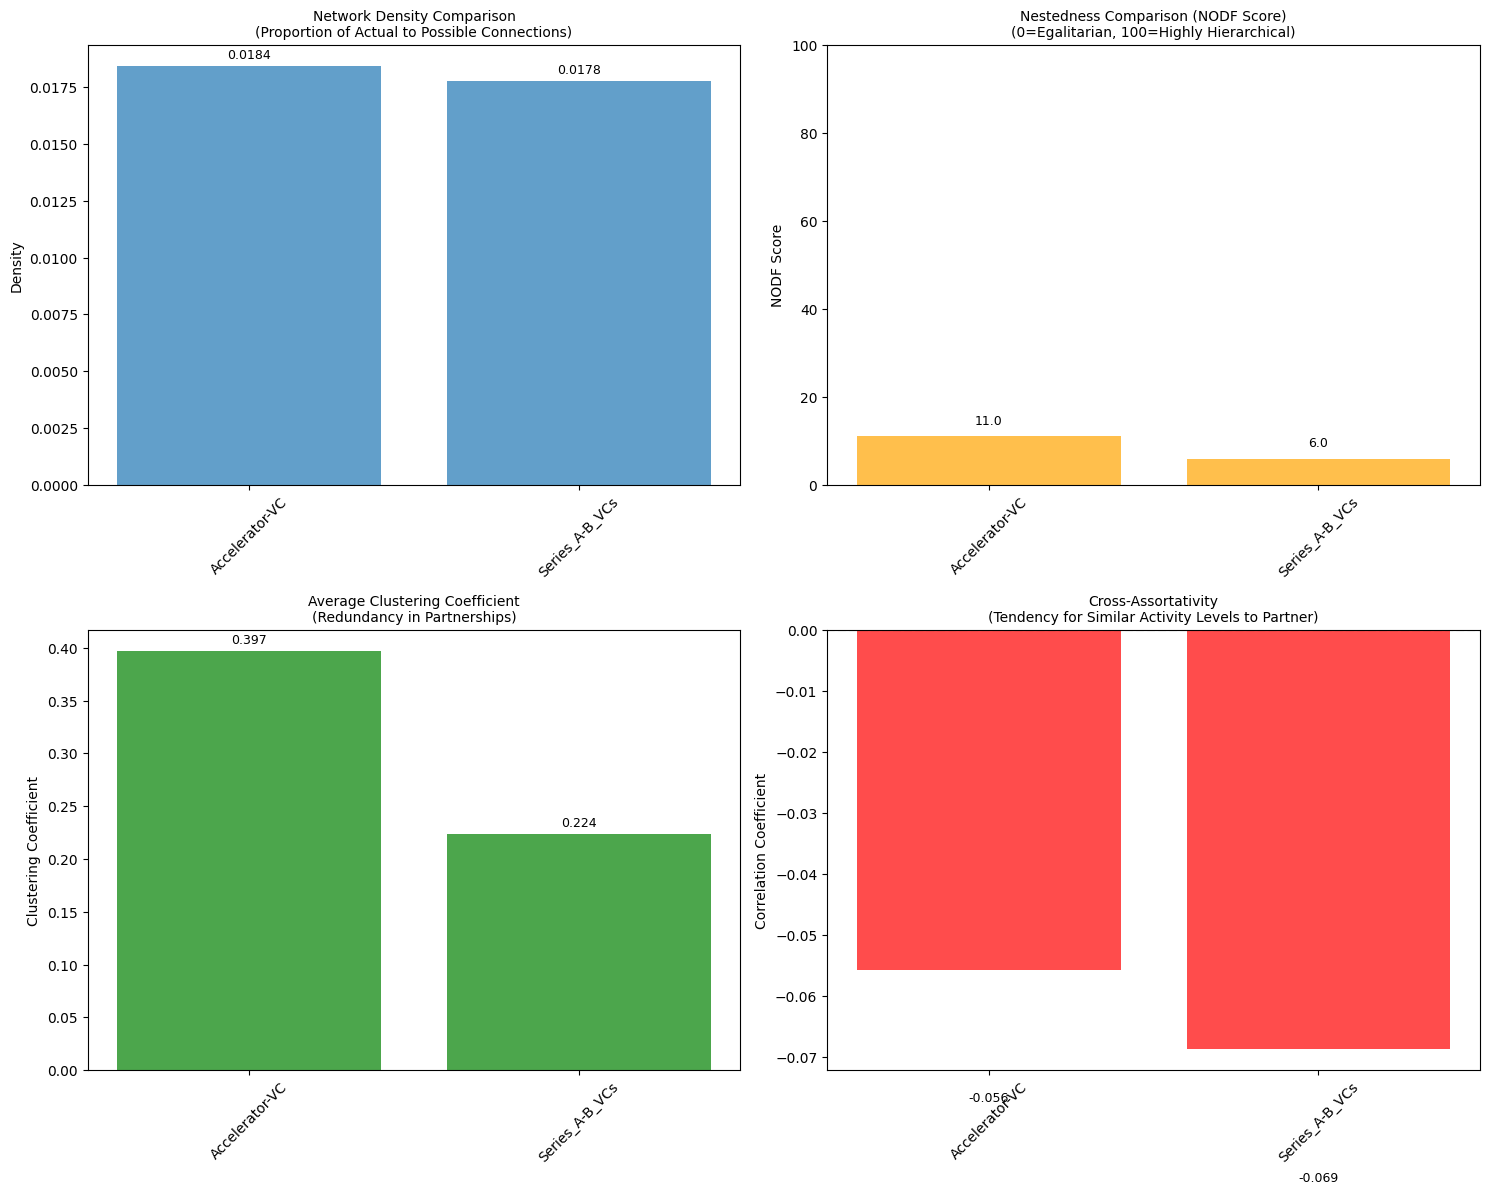


Key Comparative Insights:
  • Similar density levels across both network types
  • Similar hierarchy levels across both networks (+5.0 points difference)
  • Similar matching preferences across both network types


In [ ]:
# Compare all bipartite networks systematically
networks_comparison = compare_bipartite_networks({
    'Accelerator-VC': acc_vc_analysis,
    'Series_A-B_VCs': series_ab_analysis
})

print("Network Comparison:")
print("=" * 35)
print(networks_comparison.to_string(index=False, float_format='%.4f'))

# Create enhanced visualization comparing key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Network density comparison with context
density_data = networks_comparison['Density']
bars1 = axes[0,0].bar(networks_comparison['Network'], density_data, alpha=0.7)
axes[0,0].set_title('Network Density Comparison\n(Proportion of Actual to Possible Connections)', fontsize=10)
axes[0,0].set_ylabel('Density')
axes[0,0].tick_params(axis='x', rotation=45)
# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars1, density_data)):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(density_data)*0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=9)

# NODF nestedness comparison
nodf_data = networks_comparison['NODF_Score']
bars2 = axes[0,1].bar(networks_comparison['Network'], nodf_data, alpha=0.7, color='orange')
axes[0,1].set_title('Nestedness Comparison (NODF Score)\n(0=Egalitarian, 100=Highly Hierarchical)', fontsize=10)
axes[0,1].set_ylabel('NODF Score')
axes[0,1].set_ylim(0, 100)
axes[0,1].tick_params(axis='x', rotation=45)
# Add value labels
for bar, value in zip(bars2, nodf_data):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{value:.1f}', ha='center', va='bottom', fontsize=9)

# Clustering comparison
clustering_data = networks_comparison['Avg_Clustering']
bars3 = axes[1,0].bar(networks_comparison['Network'], clustering_data, alpha=0.7, color='green')
axes[1,0].set_title('Average Clustering Coefficient\n(Redundancy in Partnerships)', fontsize=10)
axes[1,0].set_ylabel('Clustering Coefficient')
axes[1,0].tick_params(axis='x', rotation=45)
for bar, value in zip(bars3, clustering_data):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(clustering_data)*0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Cross-assortativity comparison
assort_data = networks_comparison['Cross_Assortativity']
bars4 = axes[1,1].bar(networks_comparison['Network'], assort_data, alpha=0.7, color='red')
axes[1,1].set_title('Cross-Assortativity\n(Tendency for Similar Activity Levels to Partner)', fontsize=10)
axes[1,1].set_ylabel('Correlation Coefficient')
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1,1].tick_params(axis='x', rotation=45)
for bar, value in zip(bars4, assort_data):
    y_pos = value + 0.02 if value >= 0 else value - 0.02
    axes[1,1].text(bar.get_x() + bar.get_width()/2, y_pos,
                   f'{value:.3f}', ha='center', va='bottom' if value >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# Quantitative comparison insights
print(f"\nKey Comparative Insights:")

# Density comparison
if acc_metrics['density'] > ab_metrics['density'] * 2:
    print(f"  • Accelerator-VC partnerships much denser than Series A-B VC connections")
elif ab_metrics['density'] > acc_metrics['density'] * 2:
    print(f"  • Series A-B VC connections much denser than Accelerator-VC partnerships")
else:
    print(f"  • Similar density levels across both network types")

# Hierarchy comparison
hierarchy_diff = acc_nestedness['nodf_total'] - ab_nestedness['nodf_total']
if abs(hierarchy_diff) > 15:
    if hierarchy_diff > 0:
        print(f"  • Accelerator-VC relationships significantly more hierarchical ({hierarchy_diff:+.1f} points)")
    else:
        print(f"  • Series A-B VC relationships significantly more hierarchical ({-hierarchy_diff:.1f} points)")
else:
    print(f"  • Similar hierarchy levels across both networks ({hierarchy_diff:+.1f} points difference)")

# Assortativity comparison
assort_diff = acc_assort['cross_assortativity'] - ab_assort['cross_assortativity']
if abs(assort_diff) > 0.2:
    if assort_diff > 0:
        print(f"  • Accelerator-VC matching more assortative (homophilic) than Series A-B VCs")
    else:
        print(f"  • Series A-B VC matching more assortative (homophilic) than Accelerator-VC")
else:
    print(f"  • Similar matching preferences across both network types")

## 4. Network and Clusters Visualization...